In [89]:
import pandas as pd
import numpy as np
import ipynb
import os
import seaborn as sns
from ipynb.fs.full.SurveyUpload import uploadSurvey
#from ipynb.fs.full.DataUpload import getPatterns
#from ipynb.fs.full.DataUpload import getUserDay
import json
import time
import matplotlib.pyplot as plt


from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.utils import class_weight
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from ast import literal_eval
from sklearn.impute import SimpleImputer

from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score





In [22]:
def getUserDay(df, user, day):
    """
    user [str] - in the form of the user's anonymized name (i.e. "Monkey"). Make sure to use caps if necessary
    date [str] - in the form YEAR-MONTH-DAY (i.e. "2023-03-30")
    """
    user_day = df[(df.source_file == (user + "-patternsExport.json")) & (df.date == day)]
    user_day = user_day.copy()  # Create a copy to ensure you won't affect the original DataFrame

    user_day['datetime'] = pd.to_datetime(user_day['datetime'])
    user_day['end_time'] = pd.to_datetime(user_day['end_time'], errors='coerce')  # 'coerce' will set invalid parsing to NaT

    #this fills in an endtime for the last app used that day - right now it assumes 1 minute of usage, but you could also just cut the last app from the df
    if not user_day.empty:
        user_day.iloc[-1, user_day.columns.get_loc('end_time')] = user_day.iloc[-1, user_day.columns.get_loc('datetime')] + pd.Timedelta(minutes=1)
        return user_day
    else:
        print(f"No data found for user '{user}' on day '{day}'")
    return None


In [23]:
df = uploadSurvey()
df['date'] = df['time'].dt.date
morning = df[df['TOD'] == 0]
noon = df[df['TOD'] == 1]
evening = df[df['TOD'] == 2]
df.head()


,time,name,description,sad_happy,stressed_relaxed,unmotivated_motivated,distracted_focused,unaccomplished_accomplished,bored_interested,angry_calm,...,productivity,TOD,when_focus,when_distracted,total_interactions,total_tasks,total_breaks,mind_focus,meaningful,date
0,2023-04-17 09:02:42.287,Lion,Eagerness to go about my To Do's,4,3,3,3,4,4,4,...,5.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-17
1,2023-04-17 09:04:59.898,Rabbit,"monday morning mood, however, motivated to sta...",3,2,4,2,3,4,3,...,10.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-17
2,2023-04-17 09:14:51.081,Snake,I am stressed and feel under pressure.,4,2,3,3,2,3,3,...,5.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-17
3,2023-04-17 09:20:42.626,Cat,"Stressed, anxious, trying to get into focus mo...",3,2,2,3,3,2,3,...,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-17
4,2023-04-17 09:35:00.882,Horse,"medium motivated, bit stressed, loads of meeti...",3,2,3,4,3,2,4,...,10.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-17


In [24]:
patterns = pd.read_csv('embedded_data')
patterns.head()

/var/folders/ch/zpt836l11k92sr8tpxw3jwsw0000gn/T/ipykernel_81494/1956938311.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  patterns = pd.read_csv('embedded_data')


,createdAt,title,name,bundleIdentifier,url,source_file,event,properties,date,time,datetime,end_time,delta,base_url,user,combined,ada_embedding
0,7.018799e+08,"usebeams.com - Calendar - Week of March 26, 2023",Google Chrome,com.google.Chrome,https://calendar.google.com/calendar/u/0/r/wee...,Monkey-patternsExport.json,NaN,NaN,2023-03-30,14:38:38.991083984,2023-03-30 14:38:38.991083984,2023-03-30 14:43:19.208863037,0 days 00:04:40.217779053,https://calendar.google.com/,Monkey,https://calendar.google.com/calendar/u/0/r/wee...,"[-0.007639219518750906, -0.026348605751991272,..."
1,7.018802e+08,Re: Erik x beams - leona@usebeams.com - usebea...,Google Chrome,com.google.Chrome,https://mail.google.com/mail/u/0/#inbox/FMfcgz...,Monkey-patternsExport.json,NaN,NaN,2023-03-30,14:43:37.038793945,2023-03-30 14:43:37.038793945,2023-03-30 14:43:43.726995117,0 days 00:00:06.688201172,https://mail.google.com/,Monkey,https://mail.google.com/mail/u/0/#inbox/FMfcgz...,"[0.010895753279328346, -0.0047221616841852665,..."
2,7.018808e+08,NaN,Google Chrome,com.google.Chrome,https://www.notion.so/usebeams/Kick-Off-Messag...,Monkey-patternsExport.json,NaN,NaN,2023-03-30,14:52:52.228797852,2023-03-30 14:52:52.228797852,2023-03-30 14:52:56.907240967,0 days 00:00:04.678443115,https://www.notion.so/,Monkey,https://www.notion.so/usebeams/Kick-Off-Messag...,"[-0.004148750565946102, -0.011549131013453007,..."
3,7.018808e+08,(9+) Kick-Off Message,Google Chrome,com.google.Chrome,https://www.notion.so/usebeams/Kick-Off-Messag...,Monkey-patternsExport.json,NaN,NaN,2023-03-30,14:53:15.003209961,2023-03-30 14:53:15.003209961,2023-03-30 14:55:31.685331055,0 days 00:02:16.682121094,https://www.notion.so/,Monkey,https://www.notion.so/usebeams/Kick-Off-Messag...,"[-0.009607917629182339, -0.013429478742182255,..."
4,7.018809e+08,NaN,Google Chrome,com.google.Chrome,https://www.notion.so/usebeams/Experiment-Desi...,Monkey-patternsExport.json,NaN,NaN,2023-03-30,14:55:39.450079102,2023-03-30 14:55:39.450079102,2023-03-30 14:55:50.098559082,0 days 00:00:10.648479980,https://www.notion.so/,Monkey,https://www.notion.so/usebeams/Experiment-Desi...,"[-0.001701490138657391, -0.01200355589389801, ..."


In [77]:
type(patterns['ada_embedding'][0])

str

In [37]:
unique_pairs = []
for name in patterns['user'].unique():
    name_df = patterns[patterns.user == name]
    for date in name_df['date'].unique():
        unique_pairs.append((name, date))

In [39]:
userdays = []
remaining_unique_pairs = []
above = 0
below = 0

for name, date in unique_pairs:
    userday = getUserDay(patterns, name, date)    
    if len(userday) > 100:
        userdays.append(userday)
        remaining_unique_pairs.append((name, date))
        above += 1
    else:
        below += 1


print("Number of user days left: " + str(len(userdays)))



Number of user days left: 138


In [41]:
#First find which patterns datasets are related to the survey results
data = []

ycols = ['productivity']
for name, date in remaining_unique_pairs:
    evening_matching_rows = evening[(evening['date'].astype(str) == date) & (evening['name'] == name)]
    if not evening_matching_rows.empty:
        idx = remaining_unique_pairs.index((name, date))
        x_vals = userdays[idx]
        y_vals = evening_matching_rows[ycols].iloc[0]
        data.append((x_vals, y_vals))


GPT RECOMMENDED LSTM FOR THE TIME SEQUENCE DATA

In [63]:
len(data)

85

In [60]:
X = np.empty(len(userdays),)


In [79]:
# Initialize list to store embeddings arrays
X = []

# Loop over each userday
for userday, _ in data:
    # Initialize list to store embeddings for the current userday
    embeddings_per_userday = []
    print("starting next userday")
    # Loop over each embedding in the 'ada_embedding' column
    for embedding in userday['ada_embedding']:
        # Evaluate the string to an actual list
        evaluated_embedding = literal_eval(embedding)
        
        # Convert the evaluated list to a NumPy array
        embed_array = np.array(evaluated_embedding)
        
        # Add this embedding to the current userday's list
        embeddings_per_userday.append(embed_array)
        
    # Add the embeddings list for the current userday to the overall list
    X.append(np.array(embeddings_per_userday))

# Convert X to a NumPy array of dtype=object
X = np.array(X, dtype=object)

print(X.shape)
# Output will be: (num_userdays, )
print(X[0].shape)
# Output will be: (num_embeddings_for_userday_0, embedding_dim)



(85,)
(370, 1536)


In [65]:
y = np.array([y for _,y in data], dtype=object)

In [81]:
len(X)

85

In [86]:

# Simulated data
# Let's say we have 1000 days worth of data, ada_embedding has 50 features, and each day has varying number of apps/websites visited
n_days = len(X)
n_features = len(X[0][0])

# Pad sequences so they have the same length
X_padded = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', dtype='float32')

imputer = SimpleImputer(strategy='mean')

# Apply the imputer to our data
y = imputer.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Model
model = Sequential([
    LSTM(50, input_shape=(None, n_features)),  # LSTM layer with 50 units
    Dense(1, activation='linear')  # Output layer
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

# Make predictions
# For a new day's data (already padded)
# new_day_data = np.array([...])  # Shape should be (1, padded_length, n_features)
# prediction = model.predict(new_day_data)
# print("Predicted productivity score:", prediction)


Epoch 1/10
2/2 [==============================] - 7s 2s/step - loss: 52.8267 - val_loss: 53.4605
Epoch 2/10
2/2 [==============================] - 1s 745ms/step - loss: 52.5109 - val_loss: 53.1607
Epoch 3/10
2/2 [==============================] - 1s 830ms/step - loss: 52.1760 - val_loss: 52.7862
Epoch 4/10
2/2 [==============================] - 2s 776ms/step - loss: 51.7165 - val_loss: 52.2987
Epoch 5/10
2/2 [==============================] - 2s 714ms/step - loss: 51.0973 - val_loss: 51.6291
Epoch 6/10
2/2 [==============================] - 1s 690ms/step - loss: 50.2790 - val_loss: 50.6341
Epoch 7/10
2/2 [==============================] - 1s 688ms/step - loss: 49.0167 - val_loss: 48.9554
Epoch 8/10
2/2 [==============================] - 1s 641ms/step - loss: 47.0256 - val_loss: 45.3515
Epoch 9/10
2/2 [==============================] - 1s 627ms/step - loss: 42.0186 - val_loss: 32.6117
Epoch 10/10
1/1 [==============================] - 0s 248ms/step - loss: 18.5534
Test Loss: 18.55343627

THIS MODEL SUCKS AT THE MOMENT - NEED TO REDO THE WAY I INPUT THIS DATA (CATEGORIZE VIA CLUSTERING FIRST)

Epoch 1/100
2/2 [==============================] - 13s 4s/step - loss: 57.2810 - val_loss: 57.6138
Epoch 2/100
2/2 [==============================] - 10s 7s/step - loss: 56.5432 - val_loss: 56.9350
Epoch 3/100
2/2 [==============================] - 26s 18s/step - loss: 55.8507 - val_loss: 56.1948
Epoch 4/100
2/2 [==============================] - 17s 10s/step - loss: 55.0738 - val_loss: 55.3275
Epoch 5/100
2/2 [==============================] - 11s 5s/step - loss: 53.9836 - val_loss: 54.2390
Epoch 6/100
2/2 [==============================] - 8s 4s/step - loss: 52.8861 - val_loss: 52.7340
Epoch 7/100
2/2 [==============================] - 7s 4s/step - loss: 51.2383 - val_loss: 50.2896
Epoch 8/100
2/2 [==============================] - 12s 6s/step - loss: 48.2039 - val_loss: 45.3140
Epoch 9/100
2/2 [==============================] - 17s 7s/step - loss: 42.2441 - val_loss: 34.1004
Epoch 10/100
2/2 [==============================] - 13s 8s/step - loss: 31.9830 - val_loss: 22.7704
Epoch 11/

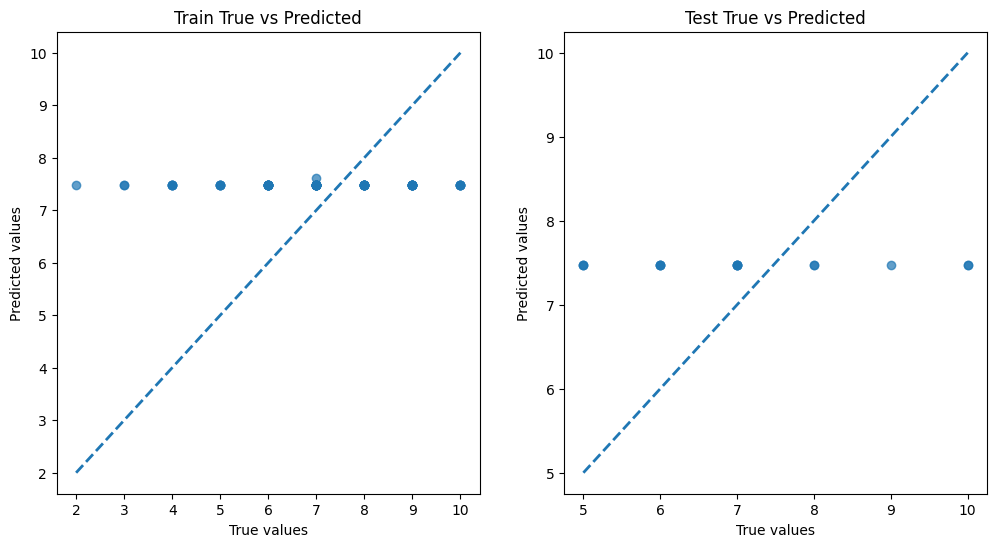

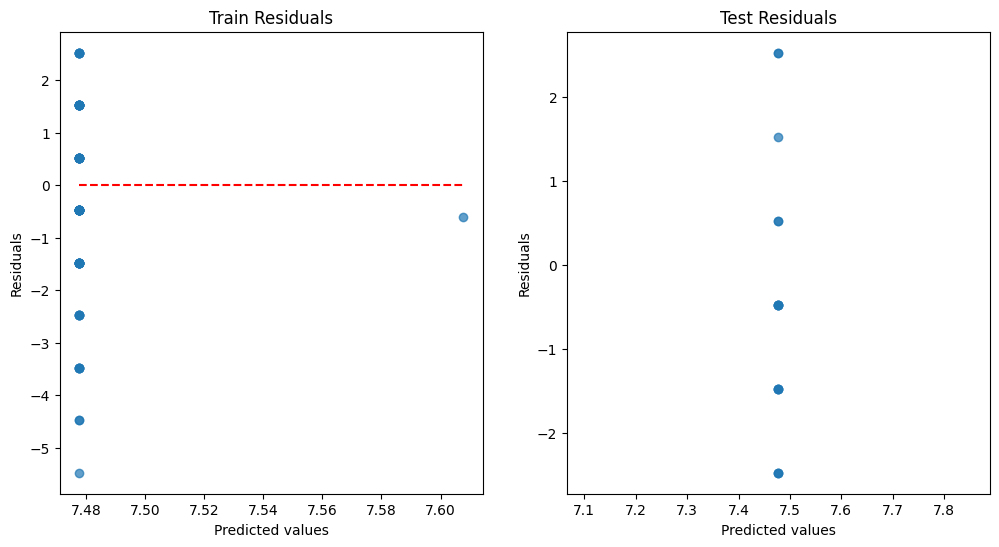

In [90]:
# Get dimensions
n_days = len(X)
n_features = len(X[0][0])

# Pad sequences so they have the same length
X_padded = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', dtype='float32')

# Impute missing values in y
imputer = SimpleImputer(strategy='mean')
y = imputer.fit_transform(y.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Model hyperparameters
lstm_units = 50
dropout_rate = 0.2
regularization_rate = 0.01

# Initialize the model
model = Sequential([
    LSTM(lstm_units, 
         input_shape=(None, n_features), 
         kernel_regularizer=l2(regularization_rate), 
         recurrent_regularizer=l2(regularization_rate), 
         bias_regularizer=l2(regularization_rate),
         dropout=dropout_rate,
         recurrent_dropout=dropout_rate),
    Dropout(dropout_rate),
    Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1, callbacks=[early_stopping])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

# ... [Your existing code to define, train, and evaluate the model]

# Making predictions on training and testing set
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# Compute RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

# Compute R-squared
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

# Print metrics
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train R-squared: {train_r2}")
print(f"Test R-squared: {test_r2}")

# Plot true vs predicted values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, train_preds, alpha=0.7)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], '--', lw=2)
plt.title('Train True vs Predicted')
plt.xlabel('True values')
plt.ylabel('Predicted values')

plt.subplot(1, 2, 2)
plt.scatter(y_test, test_preds, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', lw=2)
plt.title('Test True vs Predicted')
plt.xlabel('True values')
plt.ylabel('Predicted values')

plt.show()

# Residuals plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(train_preds, y_train - train_preds, alpha=0.7)
plt.hlines(0, min(train_preds), max(train_preds), colors='r', linestyles='--')
plt.title('Train Residuals')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
plt.scatter(test_preds, y_test - test_preds, alpha=0.7)
plt.hlines(0, min(test_preds), max(test_preds), colors='r', linestyles='--')
plt.title('Test Residuals')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')

plt.show()


In [ ]:
#Xcols = ['name', 'sad_happy', 'stressed_relaxed', 'unmotivated_motivated', 'distracted_focused', 'unaccomplished_accomplished', 'bored_interested', 'angry_calm', 'productivity']
ycols = ['productivity']

X = pd.DataFrame(columns='ada_embeddings')
y = pd.DataFrame(columns=ycols)

In [ ]:
# Normalize dataset
X_normalized = (X - X.mean()) / X.std()

# Use stratified train-test split
stratified_split = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Ensure y is an integer for multi-class classification with XGBoost
y = y.astype(int)

# Oversample the data to handle class imbalance
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_normalized, y)
y_resampled = y_resampled - 1
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

# Define objective function for Optuna optimization
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 75, 125),
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.9, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.1),
        'alpha': trial.suggest_float('alpha', 0, 0.3),
        'lambda': trial.suggest_float('lambda', 1.6, 2)
    }
    clf = xgb.XGBClassifier(**params, random_state=42, use_label_encoder=False)
    clf.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="mlogloss", eval_set=[(X_test, y_test)], verbose=False)
    return accuracy_score(y_test, clf.predict(X_test))

# Create study object and specify direction is 'maximize' for accuracy
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=100)  # Here, 100 is the number of trials, adjust as necessary.

# Results
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Now, you can use the best hyperparameters to train your final model or further analysis.
best_params = trial.params
clf_best = xgb.XGBClassifier(**best_params, random_state=42, use_label_encoder=False)
clf_best.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="mlogloss", eval_set=[(X_test, y_test)])

# Continue with predictions and evaluation as in your previous code...
# Predict on train and test set using the best estimator
train_preds = clf_best.predict(X_train)
test_preds = clf_best.predict(X_test)

# Compute accuracy
train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

# Print other metrics
print(f"Train F1-score: {f1_score(y_train, train_preds, average='macro')}")
print(f"Test F1-score: {f1_score(y_test, test_preds, average='macro')}")
print(f"Train Precision: {precision_score(y_train, train_preds, average='macro')}")
print(f"Test Precision: {precision_score(y_test, test_preds, average='macro')}")
print(f"Train Recall: {recall_score(y_train, train_preds, average='macro')}")
print(f"Test Recall: {recall_score(y_test, test_preds, average='macro')}")

# ROC-AUC is typically used for binary classification problems. For multiclass problems, you'll need to adapt it.
# If your problem is binary, you can use roc_auc_score. If it's multiclass, consider using other metrics or converting ROC-AUC for multiclass.

print(f"Train accuracy with best hyperparameters:  {train_accuracy}")
print(f"Test accuracy with best hyperparameters:  {test_accuracy}")


print("\nClassification Report:\n", classification_report(y_test, test_preds))

xgb.plot_importance(clf_best)
plt.show()

conf_matrix = confusion_matrix(y_test, test_preds)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=list(set(y_test)), yticklabels=list(set(y_test)))

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Heatmap')
plt.show()
